In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/My Drive/P1_Facial_Keypoints

[Errno 2] No such file or directory: 'drive/My Drive/P1_Facial_Keypoints'
/content/drive/My Drive/P1_Facial_Keypoints


**Load and visualize trhe data**

In [ ]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2

In [ ]:
train_df = pd.read_csv('data/training_frames_keypoints.csv')
train_df.head()

FileNotFoundError: ignored

In [ ]:
test_df=pd.read_csv("data/test_frames_keypoints.csv")

In [ ]:
test_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,64.0,27.0,67.0,30.0,71.0,33.0,75.0,39.0,76.0,46.0,76.0,52.0,74.0,56.0,72.0,59.0,67.0,62.0,62.0,63.0,57.0,64.0,52.0,65.0,47.0,27.0,40.0,30.0,39.0,32.0,...,33.0,65.0,36.0,64.0,38.0,64.0,39.0,65.0,41.0,64.0,44.0,65.0,47.0,65.0,44.0,66.0,42.0,68.0,39.0,68.0,37.0,68.0,36.0,66.0,33.0,65.0,38.0,65.0,39.0,65.0,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,101.0,57.0,108.0,60.0,114.0,65.0,121.0,75.0,127.0,88.0,124.0,98.0,122.0,106.0,117.0,114.0,112.0,122.0,102.0,124.0,94.0,129.0,87.0,129.0,76.0,57.0,52.0,60.0,50.0,65.0,...,65.0,101.0,68.0,101.0,70.0,98.0,75.0,101.0,78.0,101.0,83.0,104.0,88.0,106.0,83.0,109.0,78.0,109.0,73.0,109.0,70.0,109.0,68.0,106.0,65.0,101.0,70.0,104.0,75.0,104.0,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,127.0,73.0,135.0,78.0,137.0,83.0,140.0,96.0,143.0,109.0,138.0,119.0,135.0,127.0,130.0,132.0,125.0,135.0,115.0,135.0,105.0,137.0,95.0,137.0,84.0,63.0,75.0,65.0,70.0,71.0,...,78.0,119.0,83.0,114.0,89.0,112.0,91.0,112.0,94.0,112.0,101.0,112.0,109.0,117.0,101.0,120.0,96.0,122.0,94.0,122.0,89.0,122.0,83.0,122.0,81.0,119.0,89.0,117.0,91.0,114.0,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,128.0,64.0,135.0,73.0,139.0,83.0,144.0,96.0,144.0,105.0,137.0,107.0,133.0,107.0,127.0,109.0,120.0,109.0,112.0,109.0,103.0,109.0,95.0,107.0,86.0,60.0,83.0,66.0,79.0,73.0,...,83.0,122.0,90.0,120.0,94.0,116.0,98.0,116.0,100.0,116.0,103.0,116.0,103.0,118.0,103.0,122.0,100.0,125.0,98.0,127.0,94.0,127.0,90.0,124.0,83.0,122.0,94.0,120.0,96.0,118.0,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,96.0,51.0,103.0,58.0,108.0,66.0,112.0,76.0,112.0,85.0,107.0,91.0,100.0,94.0,93.0,96.0,84.0,96.0,77.0,96.0,70.0,96.0,64.0,94.0,55.0,42.0,67.0,48.0,65.0,51.0,...,60.0,94.0,64.0,96.0,69.0,94.0,73.0,94.0,74.0,94.0,80.0,94.0,83.0,93.0,80.0,98.0,78.0,101.0,73.0,101.0,69.0,101.0,66.0,99.0,60.0,94.0,69.0,96.0,73.0,96.0,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


In [ ]:
train_df.shape,test_df.shape

((3462, 137), (770, 137))

In the training set,there are 3462 images.  And there 136 columns for annotations means there are 68 keypoints and correspond to each keypoint we have 2(x,y) coordinates

So we have to make those data into shape of (68,2) matrix.

In [ ]:
n = 0
image_name = train_df.iloc[n, 0]
key_pts = train_df.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


Visualize

In [ ]:
def show_keypoints(image, key_pts):
  '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
  '''  
  
  plt.imshow(image)
  plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

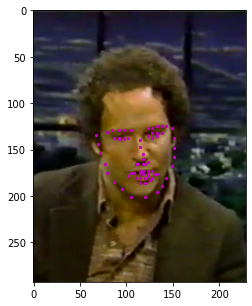

In [ ]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 5
image_name =train_df.iloc[n, 0]
key_pts = train_df.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

**Dataset Class and transformations in pytorch**

This dataset class is inspired from this [tutorial from pytorch website](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

Dataset class
torch.utils.data.Dataset is an abstract class representing a dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.

custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.
__getitem__ to support the indexing such that dataset[i] can be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will read the CSV file in __init__ but leave the reading of images to __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

A sample of our dataset will be a dictionary {'image': image, 'keypoints': key_pts}. Our dataset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face keypoints dataset."""

    def __init__(self, csv_file, root_dir,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.df.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

Now that we've defined this class, let's instantiate the dataset and display some images.

In [ ]:
# Constructing the dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


In [ ]:
#let's explore size of some iamegs
for i in range(5):
  print(face_dataset[i]["image"].shape)

(192, 176, 3)
(196, 157, 3)
(190, 170, 3)
(240, 213, 3)
(191, 184, 3)


0 (172, 142, 3) (68, 2)
1 (185, 153, 3) (68, 2)
2 (240, 264, 3) (68, 2)


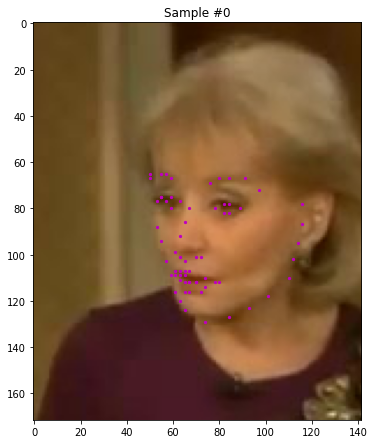

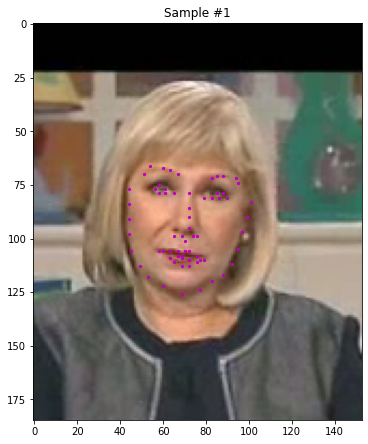

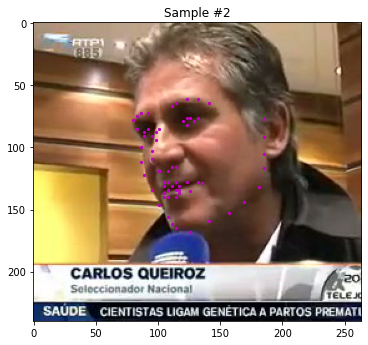

In [ ]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])


Notice the shapes of Images. They are not of same shape.
Neural networks  expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code. Let's create four transforms:

Normalize: to convert a color image to grayscale values with a range of [0,1] by dividing eith 255

Rescale: to rescale an image to a desired size.

RandomCrop: to crop an image randomly.

ToTensor: to convert numpy images to torch images.

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it's called. For this, we just need to implement __call__ method and (if we require parameters to be passed in), the __init__ method. We can then use a transform like this:

tx = Transform(params)

transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.

**Transforms**

In [ ]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Normalize the color range to [0,1] and convert a color image to grayscale if needed"""        
    def __init__(self, color = False):
        self.color = color
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        if not self.color:
            image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-2, 2]
        key_pts_copy = (key_pts_copy - image.shape[0]/2)/(image.shape[0]/4)


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
            
        img = cv2.resize(image, (new_w, new_h))
                 
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]
        
        return {'image': img, 'keypoints': key_pts}
      
class RandomCrop(object):
    """Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

Let's check out the transformation

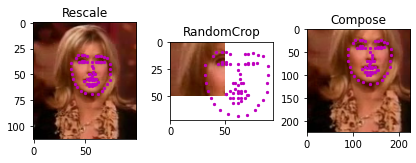

In [ ]:

# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

**Adding more transdformations for Data Augmentation**

In [ ]:
class Random90DegFlip(object):
    """Random 90 degree flip of image in sample"""
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        if random.choice([0, 1]) < .25:
            image_copy = np.rot90(image_copy,1)
            image_copy = np.flipud(image_copy)
            key_pts_copy = np.fliplr(key_pts_copy)
            

        return {'image': image_copy, 'keypoints': key_pts_copy}

In [ ]:
class RandomHorizontalFlip(object):
    """Random horizontal flip of image in sample"""
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        key_pts_copy_2 = np.copy(key_pts_copy)

        if random.choice([0, 1]) <= 0.5:
            # horizontally flip image
            image_copy = np.fliplr(image_copy)          
            # keypoints (x,y) = (-x,y)
            key_pts_copy[:,0] = -key_pts_copy[:, 0]
            # move keypoints form 2 kvadrant to 1 kvadrant
            key_pts_copy[:,0] = key_pts_copy[:, 0] + image_copy.shape[1]

            # since the keypoints are fliped around the y axis
            # their placment are wrong int the keypoint array.
            # E.g. the right eye and left eye is in the wrong place,
            # so the keypoints need to be correctly mirrord in the list
            
            key_pts_copy_2 = np.copy(key_pts_copy)
            
            # mirror jawline 
            key_pts_copy_2[16] = key_pts_copy[0]
            key_pts_copy_2[15] = key_pts_copy[1]
            key_pts_copy_2[14] = key_pts_copy[2]
            key_pts_copy_2[13] = key_pts_copy[3]
            key_pts_copy_2[12] = key_pts_copy[4]
            key_pts_copy_2[11] = key_pts_copy[5]
            key_pts_copy_2[10] = key_pts_copy[6]
            key_pts_copy_2[9]  = key_pts_copy[7]
            key_pts_copy_2[8]  = key_pts_copy[8]
            key_pts_copy_2[7] = key_pts_copy[9] 
            key_pts_copy_2[6] = key_pts_copy[10] 
            key_pts_copy_2[5] = key_pts_copy[11]
            key_pts_copy_2[4] = key_pts_copy[12]
            key_pts_copy_2[3] = key_pts_copy[13]
            key_pts_copy_2[2] = key_pts_copy[14]
            key_pts_copy_2[1] = key_pts_copy[15]
            key_pts_copy_2[0]  = key_pts_copy[16]
            
            # mirror eyebrowns
            key_pts_copy_2[26] = key_pts_copy[17] 
            key_pts_copy_2[25] = key_pts_copy[18] 
            key_pts_copy_2[24] = key_pts_copy[19]
            key_pts_copy_2[23] = key_pts_copy[20]
            key_pts_copy_2[22] = key_pts_copy[21]
            key_pts_copy_2[21] = key_pts_copy[22]
            key_pts_copy_2[20] = key_pts_copy[23]
            key_pts_copy_2[19] = key_pts_copy[24]
            key_pts_copy_2[18] = key_pts_copy[25] 
            key_pts_copy_2[17] = key_pts_copy[26]
            
            # mirror nose tip
            key_pts_copy_2[35] = key_pts_copy[31] 
            key_pts_copy_2[34] = key_pts_copy[32] 
            key_pts_copy_2[33] = key_pts_copy[33]
            key_pts_copy_2[32] = key_pts_copy[34]
            key_pts_copy_2[31] = key_pts_copy[35]
            
            # mirror eyes
            key_pts_copy_2[45] = key_pts_copy[36]
            key_pts_copy_2[44] = key_pts_copy[37] 
            key_pts_copy_2[43] = key_pts_copy[38]
            key_pts_copy_2[42] = key_pts_copy[39]
            key_pts_copy_2[47] = key_pts_copy[40]
            key_pts_copy_2[46] = key_pts_copy[41] 
            key_pts_copy_2[39] = key_pts_copy[42] 
            key_pts_copy_2[38] = key_pts_copy[43]
            key_pts_copy_2[37] = key_pts_copy[44]
            key_pts_copy_2[36] = key_pts_copy[45]
            key_pts_copy_2[41] = key_pts_copy[46] 
            key_pts_copy_2[40] = key_pts_copy[47] 
   
            # mirror lips
            key_pts_copy_2[54] = key_pts_copy[48]
            key_pts_copy_2[53] = key_pts_copy[49] 
            key_pts_copy_2[52] = key_pts_copy[50]
            key_pts_copy_2[51] = key_pts_copy[51]
            key_pts_copy_2[50] = key_pts_copy[52]
            key_pts_copy_2[49] = key_pts_copy[53] 
            key_pts_copy_2[48] = key_pts_copy[54]
            
            key_pts_copy_2[59] = key_pts_copy[55]
            key_pts_copy_2[58] = key_pts_copy[56]
            key_pts_copy_2[57] = key_pts_copy[57]
            key_pts_copy_2[56] = key_pts_copy[58] 
            key_pts_copy_2[55] = key_pts_copy[59]
            
            key_pts_copy_2[64] = key_pts_copy[60]
            key_pts_copy_2[63] = key_pts_copy[61] 
            key_pts_copy_2[62] = key_pts_copy[62]
            key_pts_copy_2[61] = key_pts_copy[63]
            key_pts_copy_2[60] = key_pts_copy[64]
                 
            key_pts_copy_2[67] = key_pts_copy[65] 
            key_pts_copy_2[66] = key_pts_copy[66] 
            key_pts_copy_2[65] = key_pts_copy[67]

            
        return {'image': image_copy, 'keypoints': key_pts_copy_2}

# inspired by 
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html


class Rotate(object):
    """Rotate image in sample by an angle"""
    
    def __init__(self, rotation):
        self.rotation = rotation
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        
        rows = image.shape[0]
        cols = image.shape[1]
        
        M = cv2.getRotationMatrix2D((rows/2,cols/2),90,1)
        image_copy = cv2.warpAffine(image_copy,M,(cols,rows))
                
        
        key_pts_copy = key_pts_copy.reshape((1,136))
        new_keypoints = np.zeros(136)
        
        for i in range(68):
            coord_idx = 2*i
            old_coord = key_pts_copy[0][coord_idx:coord_idx+2]
            new_coord = np.matmul(M,np.append(old_coord,1))
            new_keypoints[coord_idx] += new_coord[0]
            new_keypoints[coord_idx+1] += new_coord[1]
        
        new_keypoints = new_keypoints.reshape((68,2))
        
        return {'image': image_copy, 'keypoints': new_keypoints}

In [ ]:
class RandomRotate(object):
    """Rotate image in sample by an angle"""
    
    def __init__(self, rotation=30):
        self.rotation = rotation
    
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        
        rows = image.shape[0]
        cols = image.shape[1]
        
        M = cv2.getRotationMatrix2D((rows/2,cols/2),random.choice([-self.rotation, self.rotation]),1)
        image_copy = cv2.warpAffine(image_copy,M,(cols,rows))
                
        
        key_pts_copy = key_pts_copy.reshape((1,136))
        new_keypoints = np.zeros(136)
        
        for i in range(68):
            coord_idx = 2*i
            old_coord = key_pts_copy[0][coord_idx:coord_idx+2]
            new_coord = np.matmul(M,np.append(old_coord,1))
            new_keypoints[coord_idx] += new_coord[0]
            new_keypoints[coord_idx+1] += new_coord[1]
        
        new_keypoints = new_keypoints.reshape((68,2))
        
        return {'image': image_copy, 'keypoints': new_keypoints}

We added some geometrical transformation.There is also scope for more. But enough for Now.
Let's see how those transformation panned out.

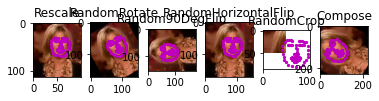

In [ ]:

# test out some of these transforms
rescale = Rescale(100)
rotate=RandomRotate(30)
v_flip=Random90DegFlip()
h_flip=RandomHorizontalFlip()
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),RandomRotate(30),Random90DegFlip(),
                               RandomHorizontalFlip(),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale,rotate,v_flip,h_flip, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 6, i + 1)
    #plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

I have to put created  classes of FacialKeypointsDataset and transforms to "load_data.py" .such that we can use them in further notebooks for modellling.